# Identifying cases of Tuberculosis in X-ray images

This notebook uses a dataset of **chest X-ray images** to attempt **detection of active Tuberculosis (TB)** as a classification problem. 
Tuberculosis is an infectious disease caused by Mycobacterium tuberculosis (MTB) bacteria and most often affects the lungs (90% of cases, hence the focus on chest X-ray images). Most infections do not have symptoms, however, **10% of infections progress to active disease** which, if left untreated, may kill the infected. The WHO estimates that **25% of the world's population** is currently infected with TB which leads to **1.3m deaths per year**(1).

The purpose of this notebook is to train a machine learning model (a convolutional neural network in combination with some dense layers) to detect signs of the active disease, specifically the result of the cell-mediated immune response to a local infection (a **granuloma**) and its resulting patches of **dead tissue (caseous necrosis)** and the associated **scar tissue** which can be observed on X-ray images (see image below as example). With further progression of the infection, lung cavities can also occur (which again, can be observed on X-ray images). 

(1) http://www.who.int/en/news-room/fact-sheets/detail/tuberculosis

<img src='images/TB_image.jpg' width='600' height='600'/>



### Approach 
This notebook encompasses broadly three sections: 

1. Data formatting and augmentation 
2. Training of ML model
3. Discussion of results 

Working with X-ray images of only 662 patients, we will use a pre-trained image classifier to extract image features first. This will be embedded within a model function that also receives some patient data (gender, and age bracket) and will evaluate it jointly with the corresponding X-ray image. The model function itself will be embedded within tensorflow's "train_and_evaluate" utility function. The visualization will be done through Tensorboard as well as custom functions within this notebook. We will be using the mobilenet version mobilenet_v1_025_224 with 470,000 parameters as image classifier. More details can be found here: https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet_v1.md

**Tensorflow hub:** We will access the model graph and pre-trained weights of the mobilenet model through the tensorflow hub functionality (see tf hub announcement and introduction from March 2018: https://medium.com/tensorflow/introducing-tensorflow-hub-a-library-for-reusable-machine-learning-modules-in-tensorflow-cdee41fa18f9). 

### Result:
The model trains to **c. 85% accuracy** on the evaluation set when pre-processing the images using local histogram / rank equalization in combination with the smallest version of the mobilenet image classifier (i.e., with 470k instead of 4.2m parameters). For the model, this translates into the following sensitivity and specificity rates: 

- **sensitivity (true positive rate): 91%**
- **specificity (true negative rate): 76%**

A study in the European Resperatory Journal from 2017 (2) has observed that the **performance of human radiologist** on X-ray images on this task was as follows:

- **sensitivity (true positive rate): 91%**
- **specificity (true negative rate): 58%**

However, the model results should be treated with some caution, as they were obtained on a sample of c.100 images (due to the overall small dataset size). The model performance can very likely be drastically improved with more training data and a more careful model setup (see the following two sections). However, achieving **superhuman performance** seems very much within the reach of this model setup. 

Using either a model with more trainable parameters (e.g., mobilenet_v1_100_224, or Inception v3) does not seem to achieve better results in this setup. 

### Model limitations:
There are broadly two major limitations to this model:
1. **Number of training images available:** we are relying on only 652 training images (after removing those of infants in the dataset). Given that image classifiers are typically trained on millions of images, this likely limits the detection accuracy quite severely. Using the pre-trained mobilenet image classifier as feature extractor seeks to mitigate this shortcoming somewhat, however, it is by no means a replacement for training on a large dataset
2. **Resolution of training images;** in order for the model to train within a reasonable time frame on a local machine (Intel Core i7-7500U, Intel HD Graphics 620, 16 GB LPDDR3-1866 of RAM), we need to significantly reduce the image resolution to at most **224x224 pixels** (which is also the largest input size of the mobilenet model). The effect can be slightly mitigated by **taking zoomed crops of the lung area of the X-ray image and then downscaling the resolution.** 

### Discussion: 
There are likely two crucial steps for drastically improving model detection accuracy, both primarily related to the model training data:
1. Increase number of training images; 662 training images is a rather small number of training images for typical machine learning tasks
2. Only ingest precise image crops of the lung area (i.e., cut-outs); this would require training another machine learning model to detect the edges of the chest cavity on an X-ray image as a polygon which would then be passed to the image classifier. This would focus the model on the lung area in the same way as a medical professional would focus his attention.

More thorough hyperparameter tuning (on a more powerful compute engine) might have slightly improved on the above results, however, I believe substantial improvements likely lie within data quality and quantity

### About the dataset: 

The complete dataset comprises of **662 de-identified high-resolution frontal chest X-ray images from a roughly equal number of patients with and without signs of TB.** Quoting from Jaeger et.al.(3): 

*"The Shenzhen dataset was collected in collaboration with Shenzhen No.3 People’s Hospital, Guangdong Medical College, Shenzhen, China. The chest X-rays are from outpatient clinics and were captured as part of the daily hospital routine within a 1-month period, mostly in September 2012, using a Philips DR Digital Diagnost system. The set contains 662 frontal chest X-rays, of which 326 are normal cases and 336 are cases with manifestations of TB, including pediatric X-rays (AP). The X-rays are provided in PNG format. Their size can vary but is approximately 3K × 3K pixels."*

(2) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5460641/
(3) https://lhncbc.nlm.nih.gov/system/files/pub9356.pdf

### Loading python libraries

In [2]:
# importing packages
import h5py
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import seaborn as sns
from skimage import exposure
from skimage import transform
from skimage.morphology import disk
from skimage.filters import rank
from skimage.filters.rank import enhance_contrast
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub

### Sample images

Below are two sample images at full resolution, one with and one without signs of TB. From the images, it becomes clear how subtle the signs of TB can be (at least to the untrained eye)

In [276]:
# side by side image plotting function
def plot_side_by_side(img1, img2, label1, label2): 
    fig = plt.figure(1, figsize=(14,14))
    i1 = fig.add_subplot(121).set_xlabel(label1, fontsize=18)
    plt.imshow(img1, cmap='gray')
    i2 = fig.add_subplot(122).set_xlabel(label2, fontsize=18)
    plt.imshow(img2, cmap='gray')
    plt.show()

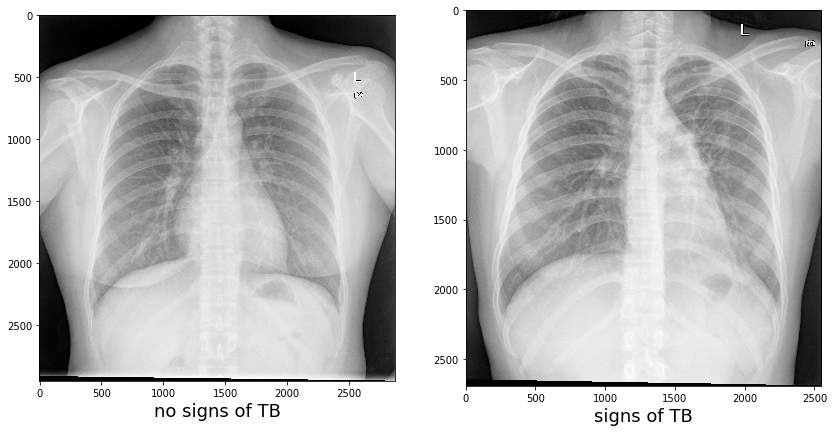

In [278]:
img1 = mpimg.imread('data\Shenzhen_Xray\CXR_png\CHNCXR_0021_0.png')
img2 = mpimg.imread('data\Shenzhen_Xray\CXR_png\CHNCXR_0410_1.png')
plot_side_by_side(img1, img2, label1='no signs of TB', label2='signs of TB')

# 1. Data formatting and augmentation

## Loading the data and image pre-processing

The images can be downloaded here: http://openi.nlm.nih.gov/imgs/collections/ChinaSet_AllFiles.zip 

Once the images are downloaded, we need to load them, process them, and convert them to numpy arrays of equal size. With the hopes of improving model performance, we experiment with three methods of regularizing pixel values and/or increasing contrast (i.e., global histogram equalization, local histogram / rank equalization, and morphological contrast enhancement). We will thus load the images four times; once without any transformations and once for each type of the abovementioned transformations. 

Specifically, the below function accomplishes the following: 
- load images
- convert images to grayscale scheme
- apply a choice of image transformations (i.e., histogram equalization, morphological contrast enhancement, and local histogram equalization) 
- for each image, take three crops; one for the entire lung area, one zoom on the top left lung, and one zoom on the top right lung. These three crops get stored as one channel respectively of one image 
- resize the images to the specified number of pixels (224x224 in this case)
- extract patient data for each image (gender, and age) 
- extract labels from the image filenames following the naming convention of ...X.png, where X can be either 0 (patient shows no signs of TB) or 1 (patients shows signs of TB). 

In [279]:
# load, and transform images, extract patient data, extract labels
def load_images(images_path, crop_coordinates_path, patient_data_path, image_width, image_height, 
                hist=False, morph=False, rank_hist=False):
        """
        Load, and transform images into combined numpy array. Extract patient data and labels 
        Arguments:
            images_path -- path to folder with the Xray PNG images 
            crop_coordinates_path -- path to json file with xy cropping coordinates for each image 
            patient_data_path -- path to folder with txt files holding patient data for each image (gender, age, diagnosis) 
            image_width -- desired output image width (in pixels)
            image_height -- desired output image height (in pixels)
            hist -- boolean, apply histogram equalization to image 
            morph -- boolean, apply morphological contrast enhancement to image 
            rank_hist -- boolean, apply local histogram equalization to image 
        Returns:
            images -- numpy array of images of shape (num_images, height, width, channels)
            patient_data -- numpy array of shape (num_images, 3), where the second dimension contains gender (male=0, female=1),
                            age, and the associated Xray image name for each row (e.g., CHNCXR_0510_1)
            labels -- label vector of shape (num_images,)
        """
        # prevent deprecation warnings
        import warnings
        warnings.filterwarnings("ignore")
        
        # PREPARE IMAGES 
        image_width = image_width
        image_height = image_height
        image_files = os.listdir(images_path)
        num_images = len(image_files)
        
        # create three channel image array 
        images = np.ndarray(shape=(num_images, image_width, image_height, 3), dtype=np.float32)
        
        # load cropping coordinates into pandas dataframe 
        crop_df = pd.read_json(crop_coordinates_path)
        
        # PREPARE PATIENT DATA
        patient_data = np.ndarray(shape=(num_images, 3), dtype=object)
    
        # PREPARE LABELS     
        labels = np.ndarray(shape=(num_images), dtype=np.int32)
        
        # Iterate through images to find useful images for the dataset 
        num_useful_images = 0
        current_channel = 0 
        image_areas = ['full', 'left', 'right']
        for image in image_files:
            try:
                # establish path to individual image and return as numpy array 
                image_file = os.path.join(images_path, image)
                img = mpimg.imread(image_file)
                                                            
                # PROCESS IMAGES 
                # Convert to gray - See stackexchange discussion: https://tinyurl.com/y8d8rhbr 
                img = np.dot(img[..., :3], [0.299, 0.587, 0.114])    
                
                # apply image transformations
                if hist is True: 
                    img = exposure.equalize_hist(img)            
                    
                if morph is True: 
                    img = rank.equalize(img, selem=disk(70))
                      
                if rank_hist is True:
                    img = enhance_contrast(img, disk(70))
                          
                # take image crops 
                height = img.shape[0] 
                width = img.shape[1]
                
                # identify row in crop boxes dataframe that corresponds to current image
                dataframe_index = int(crop_df.index[crop_df['External ID']==image][0])
                
                for area in image_areas:
                                            
                    xmin = crop_df['Label'][dataframe_index][area][0]['geometry'][1]['x']
                    xmax = crop_df['Label'][dataframe_index][area][0]['geometry'][3]['x']
                    ymin = crop_df['Label'][dataframe_index][area][0]['geometry'][3]['y']
                    ymax = ymin + (xmax-xmin)

                    img_crop=img[ymin:ymax, xmin:xmax]
                                 
                    # rescale image 
                    img_center = transform.resize(img_crop, output_shape=(image_width, image_height), mode='reflect',
                                             anti_aliasing=True) 
                    
                    # reshape image     
                    image_data = img_center.astype(float).reshape((image_width, image_height)) 

                    # save to images output array 
                    images[num_useful_images, :, :, current_channel%3] = image_data
                    current_channel +=1 
                    
                # EXTRACT PATIENT DATA
                # establish path corresponding to currently processed image 
                patient_path = os.path.join(patient_data_path, image[0:13]+'.txt')
                patient_datum = pd.read_csv(patient_path,sep='\t')
                
                # extract data 
                gender = str(list(patient_datum)).split()[0][2:]
                if gender == 'male': 
                    gender = 0
                else:
                    gender = 1 
                try: 
                    age = int(str(list(patient_datum)).split()[1][:2])
                except:
                    age = int(str(list(patient_datum)).split()[1][:1])
                
                # save to output array 
                patient_data[num_useful_images, :] = age, gender, str(image[0:13])
                
                # EXTRACT LABELS
                # If filename ends with a 1, it means the image is a case of TB 
                if str(image_file[-5]) == "1":
                    labels[num_useful_images] = 1
                else:
                    labels[num_useful_images] = 0
                num_useful_images += 1
                
                # print completion status of loading images 
                if (int(num_useful_images/num_images*1000)/10 % 10) == 0: 
                    print('Completion:', str(int(num_useful_images/num_images*100))+'%')
                
            except IOError as e:
                print('Could not read:', image_file, ':', e, '- image will be skipped.')
                          
        # Limits dataset to only valid images found
        images = images[0:num_useful_images, :, :, :]
        patient_data = patient_data[0:num_useful_images,:]
        labels = labels[0:num_useful_images]
       
        return images, patient_data, labels
        print('Full dataset tensor shape :', dataset.shape)

### Execute load function

The function below is executed four times, once for each type of image processing: 

In [239]:
# load dataset and labels into numpy arrays
images_noProcessing_224, patient_data, labels = load_images('data\Shenzhen_Xray\CXR_png', 
                                                            'data\Shenzhen_Xray\Xray_crop_coordinates.json',
                                           'data\Shenzhen_Xray\ChinaSet_AllFiles\ClinicalReadings', 224, 224) 

Completion: 20%
Completion: 30%
Completion: 50%
Completion: 60%
Completion: 80%
Completion: 90%
Could not read: data\Shenzhen_Xray\CXR_png\Thumbs.db : cannot identify image file 'data\\Shenzhen_Xray\\CXR_png\\Thumbs.db' - image will be skipped.


In [259]:
# check shapes of data
print(images.shape)
print(patient_data.shape)
print(labels.shape)

(652, 224, 224, 3)
(652, 3)
(652,)


### Visualize image cropping

The image cropping has produced three versions of each image, which are stored together: 
1. Center lung
2. Left, upper lung area
3. Right, upper lung area

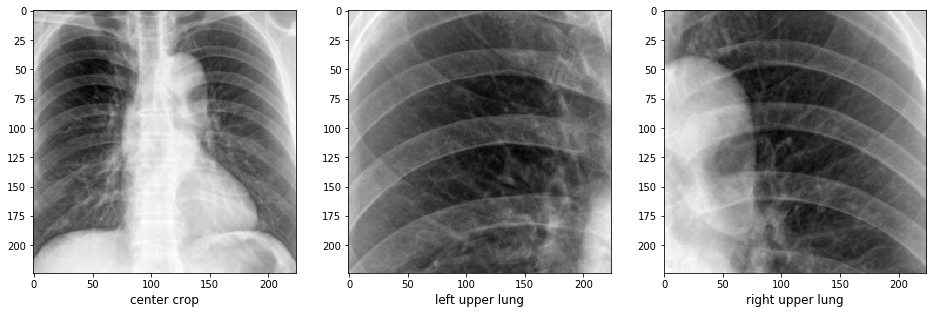

In [319]:
img1 = images_noprep[3,:,:,0]
img2 = images_noprep[3,:,:,1]
img3 = images_noprep[3,:,:,2]
fig = plt.figure(1, figsize=(16,14))
i1 = fig.add_subplot(131).set_xlabel('center crop', fontsize=12)
plt.imshow(img1, cmap='gray')
i2 = fig.add_subplot(132).set_xlabel('left upper lung', fontsize=12)
plt.imshow(img2, cmap='gray')
i3 = fig.add_subplot(133).set_xlabel('right upper lung', fontsize=12)
plt.imshow(img3, cmap='gray')
plt.show()

We can see below the result of the various transformations on the original image (looking at the center crop of the same image:

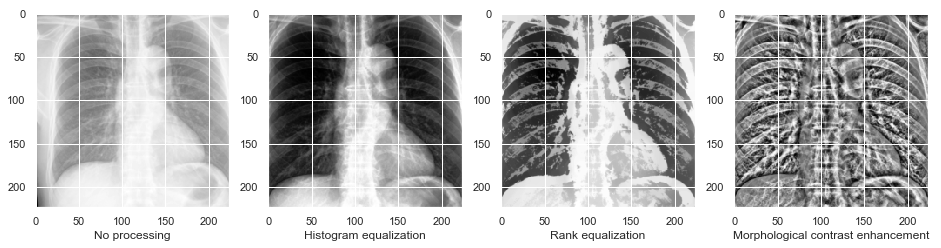

In [386]:
img1 = images_noprep[3,:,:,0]
img2 = images_hist[3,:,:,0]
img3 = images_rank70[3,:,:,0]
img4 = images_morph[3,:,:,0]
fig = plt.figure(1, figsize=(16,14))
i1 = fig.add_subplot(141).set_xlabel('No processing')
plt.imshow(img1, cmap='gray')
i2 = fig.add_subplot(142).set_xlabel('Histogram equalization')
plt.imshow(img2, cmap='gray')
i3 = fig.add_subplot(143).set_xlabel('Rank equalization')
plt.imshow(img3, cmap='gray')
i4 = fig.add_subplot(144).set_xlabel('Morphological contrast enhancement')
plt.imshow(img4, cmap='gray')
plt.show()

The local histogram / rank equalization turns out to produce the best result for the model setup:

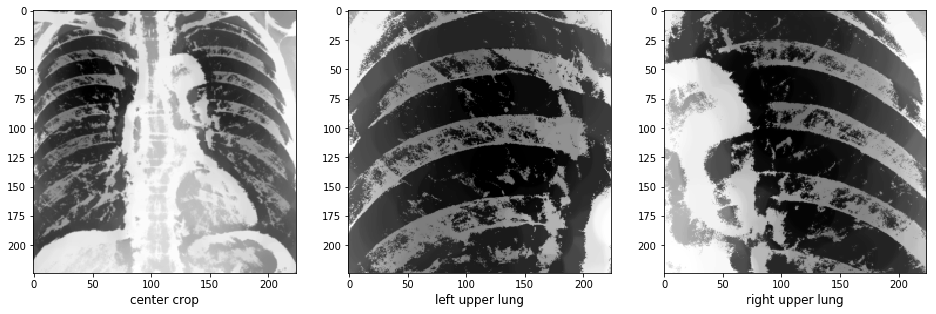

In [588]:
img1 = images[3,:,:,0]
img2 = images[3,:,:,1]
img3 = images[3,:,:,2]
fig = plt.figure(1, figsize=(16,14))
i1 = fig.add_subplot(131).set_xlabel('center crop', fontsize=12)
plt.imshow(img1, cmap='gray')
i2 = fig.add_subplot(132).set_xlabel('left upper lung', fontsize=12)
plt.imshow(img2, cmap='gray')
i3 = fig.add_subplot(133).set_xlabel('right upper lung', fontsize=12)
plt.imshow(img3, cmap='gray')
plt.show()

Plotting the pixel values for the various transformations gives us a better sense of how the distribution has changed. In the case of **histogram equalization**, we see that pixel values have evened out over the entire spectrum of brightness (orange distribution). **Rank equalization** has slightly broadened the initial distribution while preserving its overall shape (green distribution). **Morphological contrast enhancement** has centered the pixel value distribution around the value of 0.5 with some normal distribution to either side (red distribution)

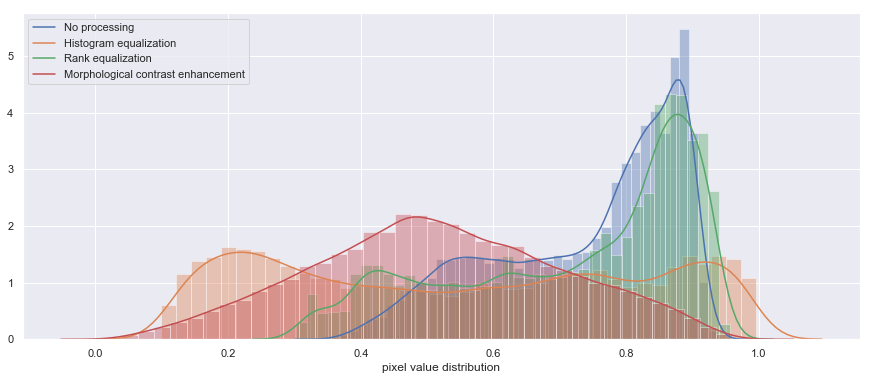

In [388]:
sns.set(rc={'figure.figsize':(15,6)})
sns.distplot(np.ndarray.flatten(images_noprep[0, :, :, 0]), bins=40,
            axlabel='pixel value distribution', kde_kws={"label": "No processing"})
sns.distplot(np.ndarray.flatten(images_hist[0, :, :, 0]), bins=40, kde_kws={"label": "Histogram equalization"})
sns.distplot(np.ndarray.flatten(images_rank70[0, :, :, 0]), bins=40, kde_kws={"label": "Rank equalization"})
sns.distplot(np.ndarray.flatten(images_morph[0, :, :, 0]), bins=40, kde_kws={"label": "Morphological contrast enhancement"})

## Data augmentation 
Since we have only a small number of images in the dataset, we will add images to the **training set** by flipping them horizontally. The evaluation set will remain untouched. We will do the following: 

1. Split dataset into a training and evaluation set (with an 85:15 ratio)
2. Data augmentation: we will one-hot-encode the age data into a number of distinct buckets to avoid having too few examples for each age. We will then apply horizontal flipping to the image training set 

### 1 Split dataset 

In [572]:
# splitting data into train and evaluation set 
def split_dataset(images, patient_data, labels, split_ratio=0.85):
    # create randon list of indices 
    num_samples = images.shape[0]
    indices = np.random.permutation(num_samples)
    split = int(num_samples * split_ratio)
     
    # split list of indices into train and dev 
    training_ind, dev_ind = indices[:split], indices[split:]
    
    # apply list of indices to images, patient data and labels 
    train_images, dev_images = images[training_ind,:,:,:], images[dev_ind,:,:,:]
    train_patient_data, dev_patient_data = patient_data[training_ind,:], patient_data[dev_ind,:]
    train_labels, dev_labels = labels[training_ind], labels[dev_ind]
    
    return train_images, dev_images, train_patient_data, dev_patient_data, train_labels, dev_labels

In [573]:
# run split function 
train_images, eval_images, train_patient_data, eval_patient_data, train_labels, eval_labels = split_dataset(images,
                                                                                                           patient_data,
                                                                                                           labels)

### 2. Data augmentation // age bucketing  and one-hot-encoding


In [574]:
# bucketing age
def one_hot_age(patient_data, bins=5):
    df = pd.DataFrame(patient_data[:,0:2])
    df['Age_bins'] = pd.cut(df[0], bins = bins, precision = 0)
    one_hot = pd.get_dummies(df['Age_bins'])
    column_labels = list(one_hot.columns.values)
    for column_label in column_labels: 
        new_label = str('Age_bins')+"_"+str(column_label)
        one_hot.rename(columns={column_label: new_label}, inplace=True)
    df = df.drop('Age_bins', axis=1)
    df = df.join(one_hot)
    df = df.drop(0, axis=1)       
    return np.array(df, dtype='float32')

In [575]:
train_patient_data_oh = one_hot_age(train_patient_data)
eval_patient_data_oh = one_hot_age(eval_patient_data)

In [576]:
# a look at the split dataset shapes
print(train_images.shape)
print(eval_images.shape)
print(train_patient_data_oh.shape)
print(eval_patient_data_oh.shape)
print(train_labels.shape)

(554, 224, 224, 3)
(98, 224, 224, 3)
(554, 6)
(98, 6)
(554,)


### 2. Data augmentation // horizontal image flipping

The below function flips all input images horizontally and can also randomly rotate each image. It also multiplies the labels (preserving the same order). The images do not need to be shuffled again, since the model input function randomly shuffles each mini batch during the training

In [578]:
# horizontally flip (with option for random rotations) of images, add to training dataset and shuffle
def flip_and_rotate(images, patient_data, labels, rotate=False):
    height_widht = images.shape[1]
    # flip images 
    flipped_images = np.flip(images, axis=2)
    combined_images = np.append(images, flipped_images, axis=0)
    combined_patient_data = np.append(patient_data, patient_data, axis=0)
    combined_labels = np.append(labels, labels, axis=0)
    # rotate images 
    if rotate is True: 
        rotated_images_90 = np.rot90(images, k=1, axes=(1,2))
        rotated_images_180 = np.rot90(images, k=2, axes=(1,2))
        rotated_images_270 = np.rot90(images, k=3, axes=(1,2))
        combined_images = np.append(combined_images, rotated_images_90, axis=0)
        combined_images = np.append(combined_images, rotated_images_180, axis=0)
        combined_images = np.append(combined_images, rotated_images_270, axis=0)
        combined_patient_data = np.append(combined_patient_data, patient_data, axis=0)
        combined_patient_data = np.append(combined_patient_data, patient_data, axis=0)
        combined_patient_data = np.append(combined_patient_data, patient_data, axis=0)
        combined_labels = np.append(combined_labels, labels, axis=0)
        combined_labels = np.append(combined_labels, labels, axis=0)
        combined_labels = np.append(combined_labels, labels, axis=0)
       
    return combined_images, combined_patient_data, combined_labels

In [579]:
# run function on training datasets 
train_images, train_patient_data_oh, train_labels = flip_and_rotate(train_images, train_patient_data_oh, train_labels, 
                                                                    rotate=False)

In [580]:
# check shapes
print(train_images.shape)
print(train_patient_data_oh.shape)
print(train_labels.shape)

(1108, 224, 224, 3)
(1108, 6)
(1108,)


Below is an example of a horizontally flipped image. Both versions will be used for training

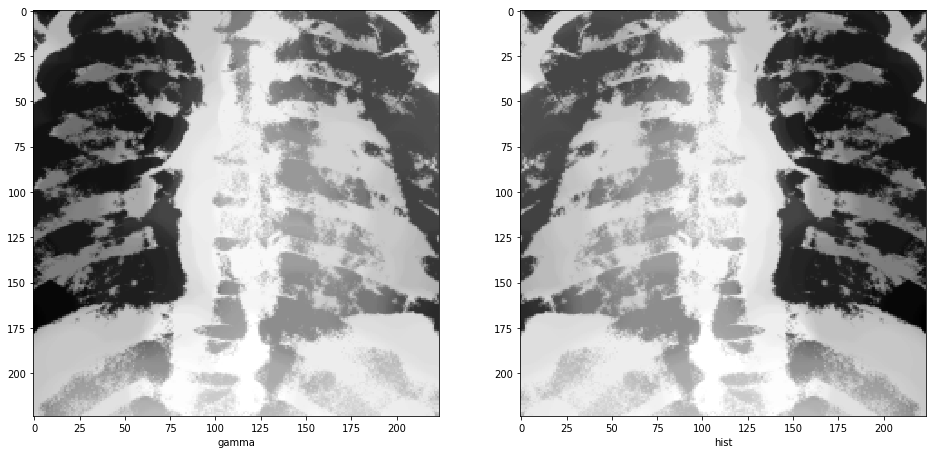

In [582]:
img1 = images[0,:,:,0]
img2 = train_images[554,:,:,0]
fig = plt.figure(1, figsize=(16,14))

i1 = fig.add_subplot(121).set_xlabel('gamma')
plt.imshow(img1, cmap='gray')
i2 = fig.add_subplot(122).set_xlabel('hist')
plt.imshow(img2, cmap='gray')

plt.show()

# 2. Setting up and training the model 

The "make_input" function serves mini batches of images and patient data during training (as well as the corresponding labels). It also randomly shuffles each mini batch during training

### Data input function 

In [444]:
# create input function.  
def make_input(images, patient_data, labels, num_epochs, batch_size=128, shuffle_state=False):
    """
    images -- numpy array of images of the shape (num_images, height, width, 3)
    patient_data -- numpy array of shape (num_images, [gender, one_hot_encoded age])
    labels -- numpy array of labels of the shape (num_images,)
    num_empochs -- set to 0 for training and 1 for evaluation and predicting 
    shuffle_state -- set to True for training 
    batch_size -- set mini batch size for training
    """
    return tf.estimator.inputs.numpy_input_fn(
        x = dict({
                'x1': images,
                'x2': patient_data 
                 }),
        y = labels,
        batch_size = batch_size,
        num_epochs = num_epochs,
        shuffle = shuffle_state,
        queue_capacity = 1000,
        num_threads = 1,    
    )    

### Model function incorporating the pre-trained mobilenet classifier

In short, the below model function processes the data in the following way:

1. Run the images through the "mobilenet" pre-trained image classifier (red box in image below) - takes in images of dimension 224x224x3 and outputs vector of size 1024
2. Run the patient data through a dense layer of 32 nodes (named "dense patient" in image below)
3. Merge the activations resulting from the images and the patient data, and run the result through three dense layers (128, 15, and 2 nodes respectively) before evaluating a prediction and the loss function

The model is also set up to allow for dropout, L1, and L2 regularization. However, given that training and evaluation loss are very close on the tensorboard visualization (see training discussion below), it is not used

#### Summary of some hyperparameters: 
- Activation function: Leaky ReLU 
- Dropout: None 
- L1 regularization: None 
- L2 regularization: None 
- Loss function: Cross entropy (as sparse softmax function) 
- Optimizer: Adam 
- Learning rate: 0.00002
- Batch size: 32 

### Model architecture

<img src='images/Xray_model.PNG' width='600' height='600'/>

Some helpful resources:
- Dealing with tags in tensorflow hub: https://stackoverflow.com/questions/50710889/tensorflow-hub-tags-and-exporting 
- Adding regularization globally: https://stackoverflow.com/questions/40709074/binary-classification-in-tensorflow-unexpected-large-values-for-loss-and-accura

In [518]:
def imagenet_model_fn(features, labels, mode):
    
    # set directory to save mobilenet graph and checkpoints 
    os.environ["TFHUB_CACHE_DIR"] = 'CHECKPOINTS/mobilenet'
    # set link to download mobilenet (also determining version) 
    module_link = "https://tfhub.dev/google/imagenet/mobilenet_v1_025_224/feature_vector/1"

    # prepare dropout 
    keep_prob_images = 1
    keep_prob_patient_data = 1
    
    # set module parameters to trainable when in TRAIN mode and set dropout rates  
    if mode == tf.estimator.ModeKeys.TRAIN:
        module = hub.Module(module_link, tags=None, trainable=True) 
        keep_prob_images = 1
        keep_prob_patient_data = 1
        print('Training..')
    
    else: 
        module = hub.Module(module_link, trainable=True) 
        print("Evaluating..")
        
    # PROCESS IMAGES  
    # import image batch from features 
    input_images = features["x1"]
    
    # run image batch through module and return a [batch_size, 1024] output layer 
    outputs = module(input_images)
    
    # apply dropout
    dropout_images = tf.nn.dropout(outputs, keep_prob_images, name='image_dropout')
    
    # PROCESS PATIENT DATA
    # import patient data from features 
    input_patient_data = features["x2"]
    
    # run patient data through dense layer and apply droput 
    dense_patient_data = tf.layers.dense(inputs=input_patient_data, units=32, activation=tf.nn.leaky_relu, name='dense_patient')
    dropout_patient_data = tf.nn.dropout(dense_patient_data, keep_prob_patient_data) 
    
    # MERGE IMAGE AND PATIENT DATA ACTIVATIONS 
    concat = tf.concat((dropout_images, dropout_patient_data), axis=1, name='concat')
    
    # APPLY MORE DENSE LAYERS        
    dense_concat_128 = tf.layers.dense(inputs=concat, units=128, activation=tf.nn.leaky_relu)
    dense_concat_15 = tf.layers.dense(inputs=dense_concat_128, units=15, activation=tf.nn.leaky_relu)
        
    # FINAL LAYER WITH TWO ACTIVATIONS (one for "TB" and one for "no TB")
    logits = tf.layers.dense(inputs=dense_concat_15, units=2, activation=tf.nn.leaky_relu)
    
    # Generate predictions 
    predictions = {        
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the `logging_hook`
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
   
    # Return predictions when mode is PREDICT
    if mode == tf.estimator.ModeKeys.PREDICT:
        print("Predicting..")
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    weights   = tf.trainable_variables() 
    l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.0, scope=None)
    
    # Calculate Loss (for both TRAIN and EVAL modes) 
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits) \
    + tf.add_n([ tf.nn.l2_loss(w) for w in weights if 'bias' not in w.name ]) * 0.0 \
    + tf.contrib.layers.apply_regularization(l1_regularizer, weights) 
    
    
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.00002)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())               
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, eval_metric_ops=eval_metric_ops, predictions=predictions)

### Train and evaluate loop

In [514]:
# create the train and evaluate function
def mobilenet_train_and_evaluate(output_dir, num_train_steps):
    
    # Specify output directory  
    run_config = tf.estimator.RunConfig(
                 model_dir=output_dir,      
                 save_summary_steps=50,                       
                 save_checkpoints_steps=50)   # dictates max frequency of eval
    
    
    # specify model 
    estimator = tf.estimator.Estimator(model_fn=imagenet_model_fn,
                                      config = run_config)
         
    # specify train set
    train_spec = tf.estimator.TrainSpec(input_fn = make_input(train_images,
                                                              train_patient_data_oh,
                                                              train_labels, 
                                                              shuffle_state=True,
                                                              num_epochs=None,
                                                              batch_size=32), 
                                        max_steps = num_train_steps)
    
    # specify eval set 
    eval_spec = tf.estimator.EvalSpec(input_fn = make_input(eval_images,
                                                            eval_patient_data_oh,
                                                            eval_labels,
                                                            shuffle_state=False,
                                                            num_epochs=1,
                                                            batch_size=eval_images.shape[0]), 
                                        steps = None, 
                                        throttle_secs = 40)  # evaluates no more than every 40 seconds
    
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    
    return estimator

### Run training 

In [584]:
tf.logging.set_verbosity(tf.logging.WARN)
# run model 
mobilenet_model_Rank = mobilenet_train_and_evaluate(output_dir='CHECKPOINTS/Xray_model/rank', 
                                       num_train_steps = 60)   

Training..
Evaluating..
Training..
Evaluating..
Training..
Evaluating..
Training..
Evaluating..
Training..
Evaluating..
Training..
Evaluating..
Training..
Evaluating..
Training..
Evaluating..
Training..
Evaluating..


# 3. Evaluating results

Below is the tensorboard output of the training runs, where the **x axis shows training steps** and the **y axis accuracy on the evaluation set:** 
- Red line: No image pre-processing
- Grey line: Global histogram equalization 
- Light blue line: Local histogram / rank equalization
- Dark blue line: Morphological contrast enhancement


<img src='images/TB_training.PNG' width='600' height='600'/>


### Accuracy results: 
Running the model on our differently processed images, we observe the following **max accuracies** on the evaluation sets: 
- no image preprocessing: 81%
- (global) histogram equalization: 78%
- local histogram / rank equalization: 85%
- morphological contrast enhancement: 68%


The results are, however, just an indication. There is some statistical variation due to the comparatively small dataset and the random split of training and evaluation sets. We even see a fairly high fluctuation during training

### Showing some incorrect predictions

In order to get a better sense of the model predictions (and crucially its mistakes), we can display a few misclassified images from the top performing model below

In [531]:
def show_incorrect_predictions(model, num_show=3, eval=True): 
    # the predict method returns an iterator object from which we have to extract the class prediction
    if eval is True: 
        images, patient_data, labels, image_names = eval_images, eval_patient_data_oh, eval_labels, eval_patient_data[:,-1]
    else: 
        images, patient_data, labels, image_names = train_images, train_patient_data_oh, train_labels, train_patient_data[:,-1]
        
    predictions = list(model.predict(input_fn = make_input(images, patient_data, labels, shuffle_state=False,
                                                                 num_epochs=1, batch_size=eval_images.shape[0])))
            
    predicted_classes =[]
    for p in predictions: 
        predicted_classes.append(p['classes'])
    
    # get all labels and subtract them from predicted labels 
    predicted_classes = np.reshape(np.array(predicted_classes), (labels.shape[0],))
    delta_array = predicted_classes - labels
    
    # find index of wrongly classified images 
    error_index = np.nonzero(delta_array)[0]
    
    # choose random mis-classified images 
    error_sample = np.random.choice(error_index, num_show)

    # print mis_classified images 
    for i in error_sample: 
        print("Prediction:", str(predicted_classes[i]))
        print("Label:", str(labels[i]))
        print("Image name:", image_names[i])
        image = images[i,:,:,0]
        image = image.reshape([224, 224]);
        plt.imshow(image, cmap='gray')
        plt.show()
   
    return len(error_index)

Evaluating..
Predicting..
Prediction: 1
Label: 0
Image name: CHNCXR_0131_0


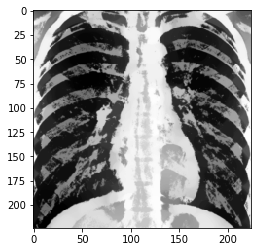

Prediction: 0
Label: 1
Image name: CHNCXR_0580_1


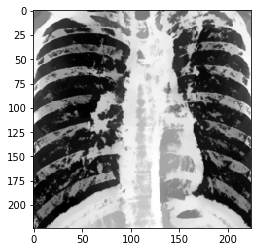

Prediction: 0
Label: 1
Image name: CHNCXR_0419_1


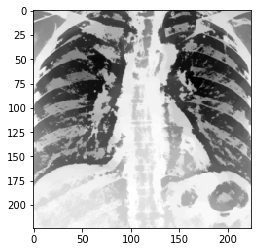

17

In [589]:
show_incorrect_predictions(mobilenet_model_Rank, 3, eval=True)

### A closer look at the results
It is also helpful to plot a confusion matrix to check for the number of true/false positives and true/false negatives. Below are functions that help plot the confusion matrix which is then plotted for the model version with local histogram / rank equalization

In [380]:
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [586]:
def show_confusion_matrix(model): 
    # compute model predictions for eval set 
    predictions = list(model.predict(input_fn = make_input(eval_images, eval_patient_data_oh, eval_labels,
                                                                 shuffle_state=False,
                                                                 num_epochs=1, 
                                                                 batch_size=eval_images.shape[0])))
    predicted_classes = [p['classes'] for p in predictions]
    predicted_classes = np.reshape(np.array(predicted_classes), (eval_images.shape[0],))
    
    # compute confusion matrix
    cm = confusion_matrix(eval_labels, predicted_classes)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, (0,1))

    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, (0,1), title='Normalized confusion matrix')

    plt.show()

The confusion matrix below helps us visualize the false/true positives/negatives (where darker shades of blue indicate higher rates of prediction). Ideally we would want to see one dark field in the top left corner and one dark field in the bottom right corner indicating only true positives and true negatives. However, in our case, we can see a signifcant rate of false negatives (24% of TB cases were not identified correctly)

Evaluating..
Predicting..
Confusion matrix, without normalization
[[39  4]
 [13 42]]
Normalized confusion matrix
[[0.91 0.09]
 [0.24 0.76]]


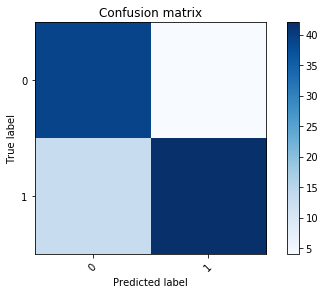

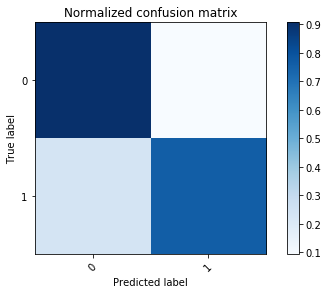

In [587]:
show_confusion_matrix(mobilenet_model_Rank)

### Interpreting the results 

Overall, it seems that using local histogram / rank equalization on the raw images is most promising in this setup. With a more complex model and more data, I would expect that global histogram equalization should achieve the best results since it regularizes the pixel spectrum equally for all images (i.e., random differences in brightness between the images might otherwise mislead the model to attaching significance to it). 

A recent study in the European Resperatory Journal (2) indicates that human radiologist level performance on X-ray images is as follows:
- sensitivity (true positive rate): 91% 
- specificity (true negative rate): 58%

The model compares as follows: 
- sensitivity (true positive rate): 91% 
- specificity (true negative rate): 76%

The model performance seems to reasonable close to the performance of radiologists (and outperforming humans on specificity). However, this result needs to be treated with some caution, as the model was only tested on c. 100 randomly selected images. 

### Potential next steps 

It seems to be desirable that the model should have a low probability of false negatives (i.e., sending people home who actually do have active TB). From the confusion matrix we can see that this rate is currently 24%. If we want to reduce this probability, we could increase the weight of TB labelled images in the model loss function. Alternatively, we could also adjust the cut-off probability during prediction (e.g., predict TB even when model outpout is only around 40% or lower probability). 

As pointed out in the introduction, there are likely two crucial steps for drastically improving model detection accuracy, both primarily related to the model training data:

1. Increase number of training images; 662 training images is a rather small number of training images for typical machine learning tasks
2. Only ingest image crops of the lung area (i.e., cut-outs); this would require training another machine learning model to detect the edges of the lung area on an X-ray image as a polygon which would then be passed to the image classifier. This would focus the model on the lung area in the same way as a medical professional would focus his attention in detectin traces of TB

More thorough hyperparameter tuning (for a more complex model run on a more powerful compute engine) might have slightly improved on the above results, however, I believe substantial improvements likely lie within data quality and quantity


(2) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5460641/